<a href="https://colab.research.google.com/github/FOTIS21/Computer-Vision/blob/master/ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import SBDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
from torch.utils.data import Dataset

class SBDWithTransforms(Dataset):
    def __init__(self, base_dataset, img_transform=None, mask_transform=None):
        self.base = base_dataset
        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, mask = self.base[idx]

        if self.img_transform is not None:
            img = self.img_transform(img)

        if self.mask_transform is not None:
            mask = self.mask_transform(mask)

        return img, mask


In [ ]:
from torch.utils.data import Subset, random_split

transform_img = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])


transform_mask = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor()
])

transforms.RandomResizedCrop(
    (256,256),
    scale=(0.6, 1.0)
)

sbd_train_base = SBDataset(
    root="data",
    image_set="train",
    mode="segmentation",
    download=False
)

sbd_val_base = SBDataset(
    root="data",
    image_set="val",
    mode="segmentation",
    download=False
)

train_dataset = SBDWithTransforms(
    sbd_train_base,
    img_transform=transform_img,
    mask_transform=transform_mask
)

test_dataset = SBDWithTransforms(
    sbd_val_base,
    img_transform=transform_img,
    mask_transform=transform_mask
)

train_sub_dataset = Subset(train_dataset, range(4000))

dataset_size = len(train_sub_dataset)
val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size

train_ds, val_ds = random_split(
    train_sub_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_ds,
                          batch_size=8,
                          shuffle=True,
                          num_workers=0,
                          pin_memory=True,
                          persistent_workers=False)

val_loader = DataLoader(val_ds,
                        batch_size=8,
                        shuffle=False,
                        num_workers=0,
                        pin_memory=True,
                        persistent_workers=False
)


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


In [ ]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.down1 = DoubleConv(3, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.middle = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        c1 = self.down1(x)
        c2 = self.down2(self.pool(c1))
        c3 = self.down3(self.pool(c2))
        c4 = self.down4(self.pool(c3))

        m = self.middle(self.pool(c4))

        u4 = self.up4(m)
        u4 = self.conv4(torch.cat([u4, c4], dim=1))

        u3 = self.up3(u4)
        u3 = self.conv3(torch.cat([u3, c3], dim=1))

        u2 = self.up2(u3)
        u2 = self.conv2(torch.cat([u2, c2], dim=1))

        u1 = self.up1(u2)
        u1 = self.conv1(torch.cat([u1, c1], dim=1))

        return self.out(u1)


In [ ]:
def mean_iou(pred, target, num_classes=21):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)

    for cls in range(num_classes):
        if cls == 255:
            continue
        pred_i = pred == cls
        target_i = target == cls

        intersection = (pred_i & target_i).sum().item()
        union = (pred_i | target_i).sum().item()

        if union == 0:
            continue
        ious.append(intersection / union)

    return np.mean(ious) if len(ious) > 0 else 0


In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs, scheduler=None):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "val_iou": []}

    for epoch in range(epochs):
        model.train()
        train_total, train_correct, train_loss = 0, 0, 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]",leave=False)

        for imgs, masks in train_bar:
            imgs = imgs.to(device)
            masks = masks.squeeze(1).long().to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = 0.7 * criterion(outputs, masks) + 1.3 * dice_loss(outputs, masks)

            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            valid = masks != 255

            train_correct += (preds[valid] == masks[valid]).sum().item()
            train_total += valid.sum().item()
            train_loss += loss.item()

            train_bar.set_postfix(
                loss=loss.item(),
                accuracy=100*train_correct / train_total
            )

        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total

        val_loss, val_acc, val_iou = validate(model, val_loader)
        if scheduler is not None:
          scheduler.step()


        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_iou"].append(val_iou)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | "
            f"Train Acc: {train_acc:.2f}, Val Acc: {val_acc:.2f}% | "
            f"Val IoU: {val_iou:.4f}"
        )

    return history


In [ ]:
def validate(model, loader, epoch=None, epochs=None):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    ious = []

    desc = "Validation" if epoch is None else f"Epoch {epoch+1}/{epochs} [Val]"
    val_bar = tqdm(loader, desc=desc, leave=False)

    with torch.no_grad():
        for imgs, masks in val_bar:
            imgs = imgs.to(device)
            masks = masks.squeeze(1).long().to(device)

            outputs = model(imgs)
            loss = criterion(outputs, masks) + dice_loss(outputs, masks)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            valid = masks != 255

            correct += (preds[valid] == masks[valid]).sum().item()
            total += valid.sum().item()

            batch_iou = mean_iou(
                preds[valid],
                masks[valid],
                num_classes
            )
            ious.append(batch_iou)

            val_bar.set_postfix(
                loss=loss.item(),
                accuracy=100 * correct / total,
                iou=batch_iou
            )

    val_loss = total_loss / len(loader)
    val_acc = 100.0 * correct / total
    mean_iou_epoch = np.mean(ious)

    return val_loss, val_acc, mean_iou_epoch


In [ ]:
def plot_training_curves(results_dict):
    plt.figure(figsize=(12,5))

    # ---- Training Loss ----
    plt.subplot(2,2,1)
    for name, history in results_dict.items():
        plt.plot(history["train_loss"], label=f"{name} Train Loss")
    plt.title("Training Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2,2,2)
    for name, history in results_dict.items():
        plt.plot(history["train_acc"], label=f"{name} Train Accuracy")
    plt.title("Training Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    # ---- Validation Accuracy ----
    plt.subplot(2,2,3)
    for name, history in results_dict.items():
        plt.plot(history["val_loss"], label=f"{name} Val Loss")
    plt.title("Validation Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2,2,4)
    for name, history in results_dict.items():
        plt.plot(history["val_acc"], label=f"{name} Val Acc")
    plt.title("Validation Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()

        # ---- Validation IoU ----
    plt.figure(figsize=(6,4))
    for name, history in results_dict.items():
        if "val_iou" in history:
            plt.plot(history["val_iou"], label=f"{name} Val IoU")

    plt.title("Validation Mean IoU")
    plt.xlabel("Epoch")
    plt.ylabel("mIoU")
    plt.legend()
    plt.grid(True)
    plt.show()



In [ ]:
def show_predictions_segmentation(model, dataset, device, n):
    model.eval()

    import random
    idxs = random.sample(range(len(dataset)), n)

    plt.figure(figsize=(12, n * 3))

    for i, idx in enumerate(idxs):
        img, mask = dataset[idx]

        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device))
            pred = torch.argmax(pred, dim=1).squeeze().cpu()

        # Image
        plt.subplot(n, 3, i*3 + 1)
        plt.imshow(img.permute(1,2,0))
        plt.title("Image")
        plt.axis("off")

        # GT
        plt.subplot(n, 3, i*3 + 2)
        plt.imshow(mask.squeeze(), cmap="jet")
        plt.title("Ground Truth")
        plt.axis("off")

        # Prediction
        plt.subplot(n, 3, i*3 + 3)
        plt.imshow(pred, cmap="jet")
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
# Dice Loss για semantic segmentation
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.softmax(pred, dim=1)

    valid = target != 255
    target = target.clone()
    target[~valid] = 0

    target_one_hot = torch.nn.functional.one_hot(
        target, num_classes=pred.shape[1]
    ).permute(0, 3, 1, 2).float()

    pred = pred * valid.unsqueeze(1)
    target_one_hot = target_one_hot * valid.unsqueeze(1)

    # ❗ ignore background (class 0)
    pred = pred[:, 1:, :, :]
    target_one_hot = target_one_hot[:, 1:, :, :]

    intersection = (pred * target_one_hot).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target_one_hot.sum(dim=(2,3))

    loss = 1 - (2 * intersection + smooth) / (union + smooth)
    return loss.mean()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
if print(torch.cuda.is_available()):
    print(torch.cuda.get_device_name(0))


num_classes = 21  # SBD semantic classes
model = UNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


cuda
True


Training with epochs=3


Epoch 1/3 | Train Loss: 2.3411, Val Loss: 2.3459 | Train Acc: 68.65, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 2/3 | Train Loss: 2.2106, Val Loss: 2.3063 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 3/3 | Train Loss: 2.2017, Val Loss: 2.3044 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842
Training with epochs=6


Epoch 1/6 | Train Loss: 2.3499, Val Loss: 2.3264 | Train Acc: 67.61, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 2/6 | Train Loss: 2.2068, Val Loss: 2.2879 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 3/6 | Train Loss: 2.1969, Val Loss: 2.2909 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 4/6 | Train Loss: 2.1928, Val Loss: 2.2973 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 5/6 | Train Loss: 2.1919, Val Loss: 2.2885 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 6/6 | Train Loss: 2.1901, Val Loss: 2.2774 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842
Training with epochs=9


Epoch 1/9 | Train Loss: 2.3293, Val Loss: 2.3244 | Train Acc: 69.75, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 2/9 | Train Loss: 2.2081, Val Loss: 2.2910 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 3/9 | Train Loss: 2.1996, Val Loss: 2.2843 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 4/9 | Train Loss: 2.1942, Val Loss: 2.2754 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 5/9 | Train Loss: 2.1922, Val Loss: 2.3010 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 6/9 | Train Loss: 2.1905, Val Loss: 2.2724 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 7/9 | Train Loss: 2.1865, Val Loss: 2.2692 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 8/9 | Train Loss: 2.1844, Val Loss: 2.2674 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 9/9 | Train Loss: 2.1831, Val Loss: 2.2743 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


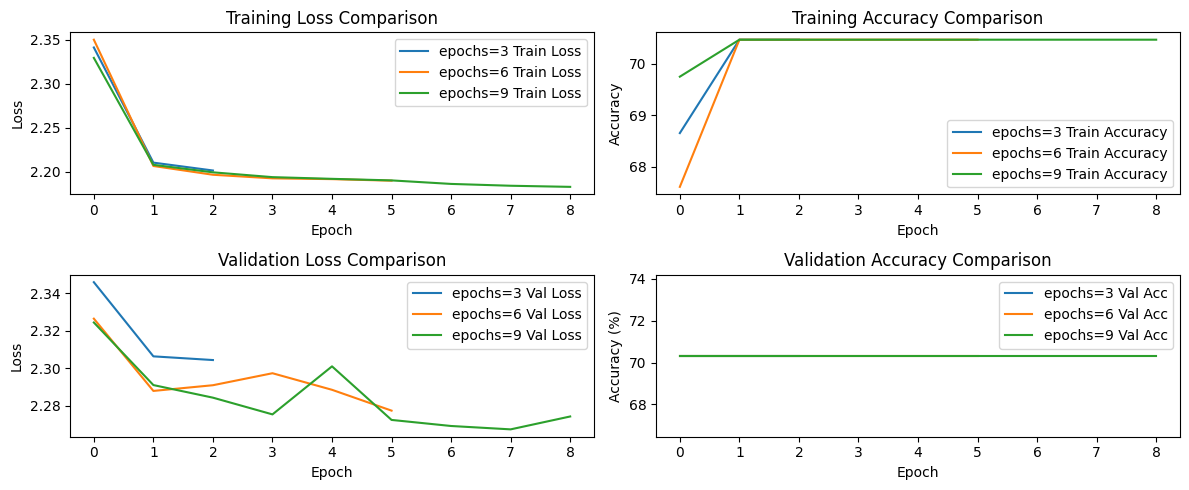

In [ ]:
results = {}

for epoch in [3, 6, 9]:
    print(f"Training with epochs={epoch}")

    model = UNet(num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss(ignore_index=255)

    history = train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=epoch)

    results[f"epochs={epoch}"] = history


plot_training_curves(results)

In [ ]:
show_predictions_segmentation(model, val_ds, device, n=8)

Training with lr=0.01


Epoch 1/5 | Train Loss: 11673866985.7589, Val Loss: 2.4085 | Train Acc: 65.95, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 2/5 | Train Loss: 2.2579, Val Loss: 2.3710 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 3/5 | Train Loss: 2.2502, Val Loss: 2.3665 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 4/5 | Train Loss: 2.2455, Val Loss: 2.3552 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 5/5 | Train Loss: 2.2401, Val Loss: 2.3485 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842
Training with lr=0.001


Epoch 1/5 | Train Loss: 2.3351, Val Loss: 2.3689 | Train Acc: 69.63, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 2/5 | Train Loss: 2.2514, Val Loss: 2.3402 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 3/5 | Train Loss: 2.2393, Val Loss: 2.3534 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 4/5 | Train Loss: 2.2322, Val Loss: 2.3270 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 5/5 | Train Loss: 2.2283, Val Loss: 2.3396 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842
Training with lr=0.0001


Epoch 1/5 | Train Loss: 2.3431, Val Loss: 2.3282 | Train Acc: 67.39, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 2/5 | Train Loss: 2.2038, Val Loss: 2.3044 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 3/5 | Train Loss: 2.1976, Val Loss: 2.2835 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 4/5 | Train Loss: 2.1924, Val Loss: 2.2803 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


Epoch 5/5 | Train Loss: 2.1914, Val Loss: 2.2754 | Train Acc: 70.47, Val Acc: 70.33% | Val IoU: 0.0842


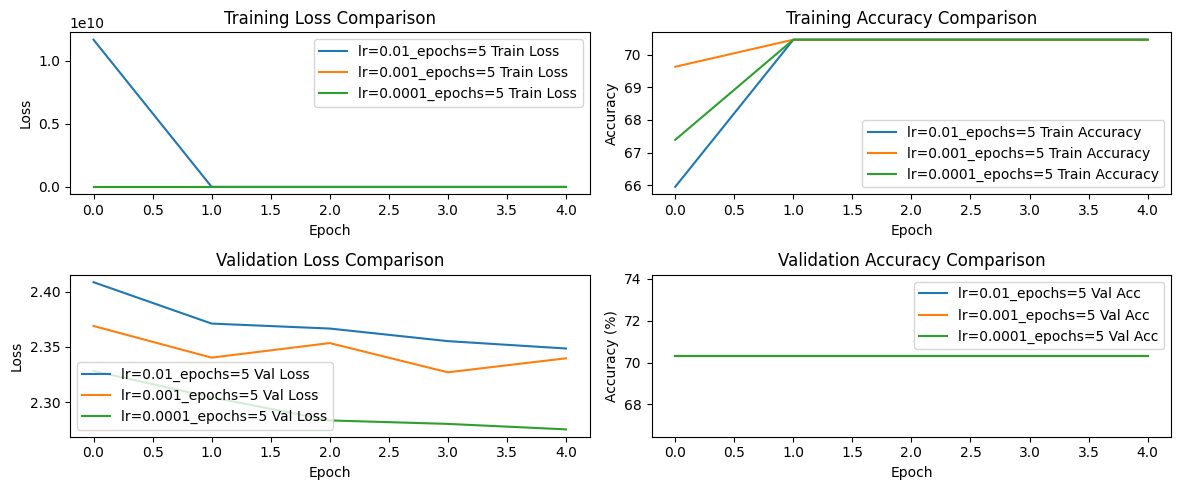

In [ ]:
lrs = [1e-2,1e-3,1e-4]
results = {}
for lr in lrs:
    print(f"Training with lr={lr}")
    model = UNet(num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=255)

    history = train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=5)

    results[f"lr={lr}_epochs=5"] = history

plot_training_curves(results)

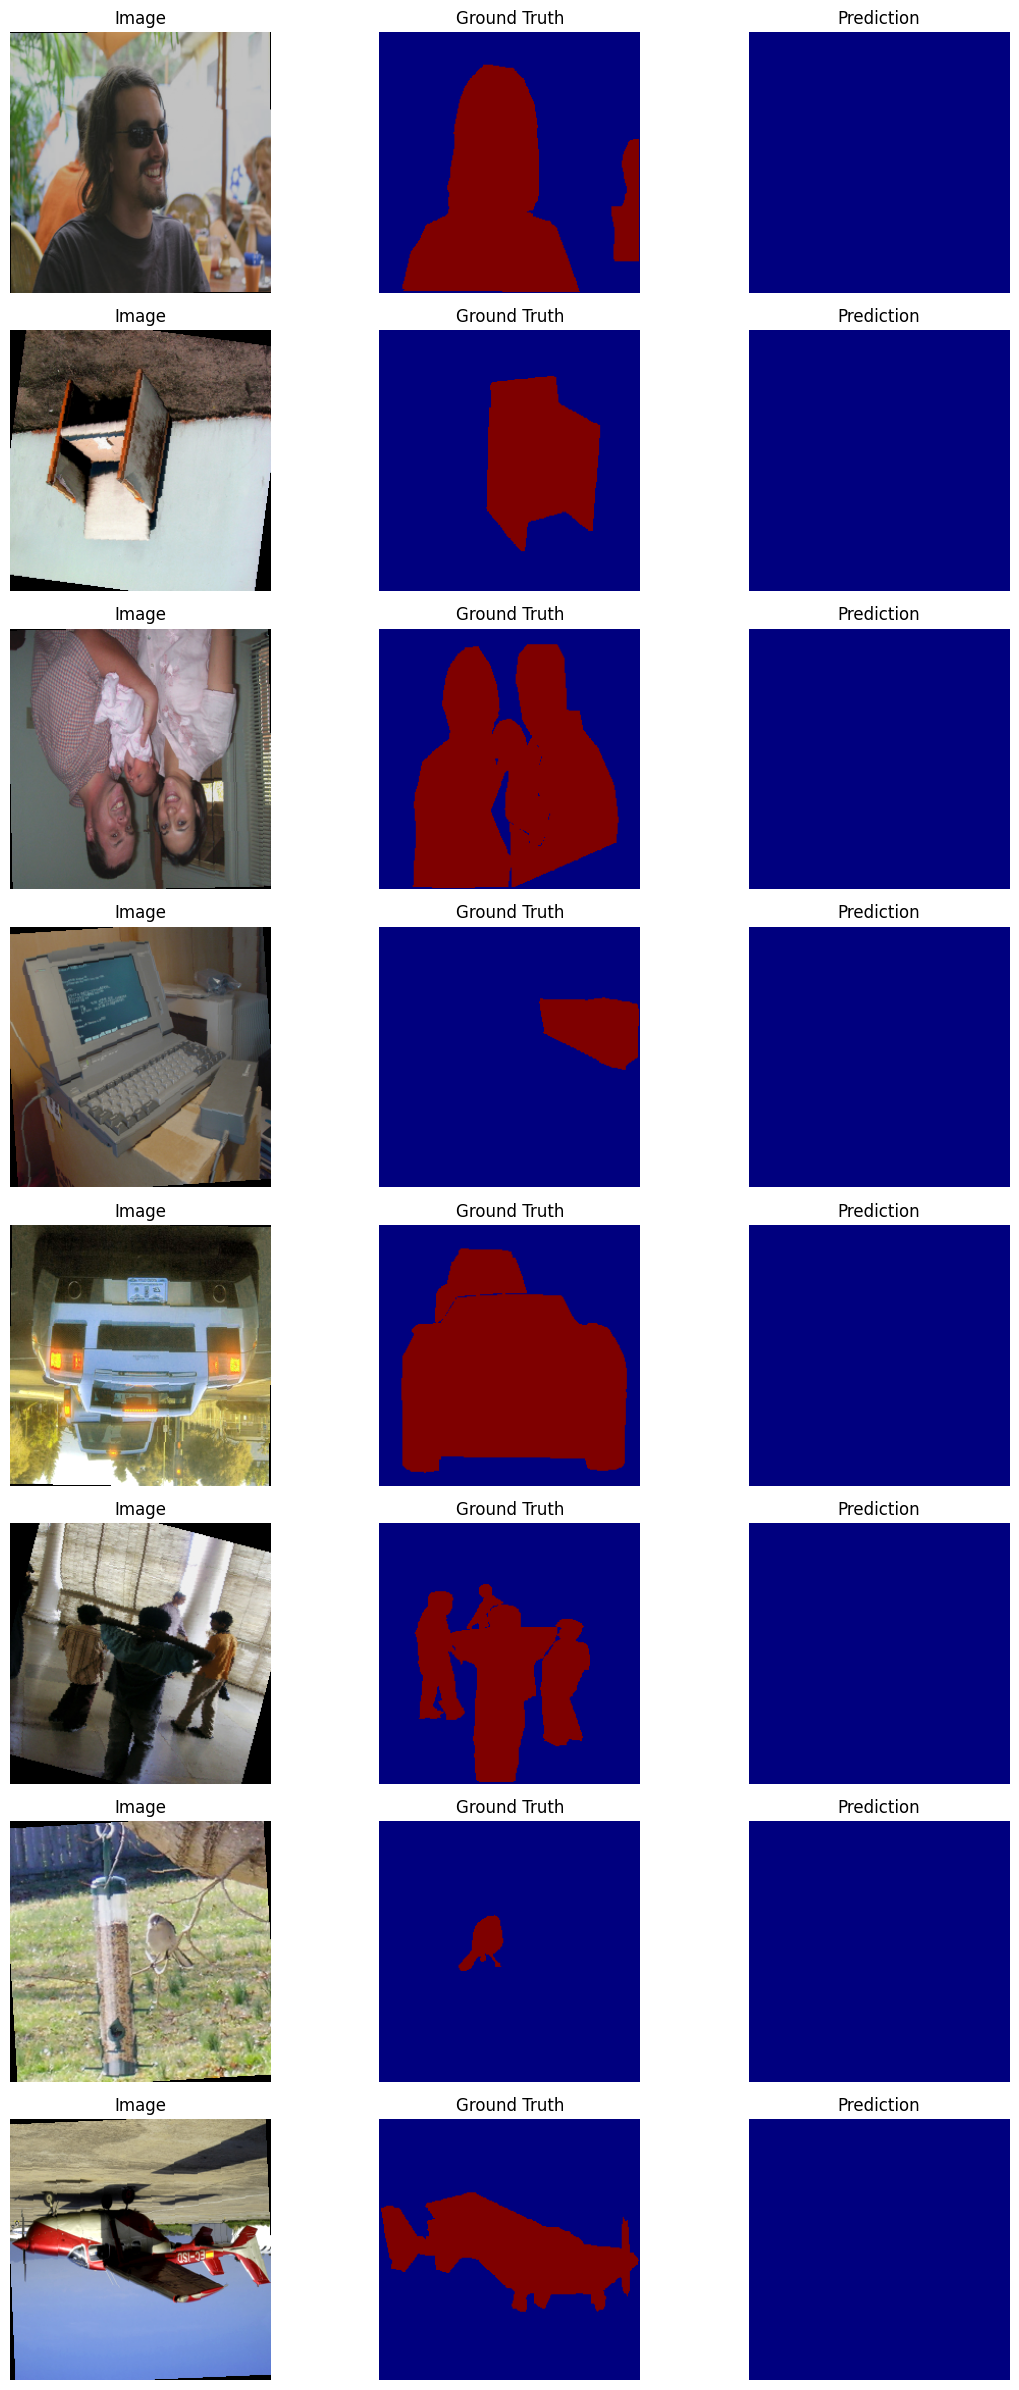

In [ ]:
show_predictions_segmentation(model, val_ds, device, n=8)

Epoch 1/9 | Train Loss: 3.1191, Val Loss: 3.5573 | Train Acc: 16.75, Val Acc: 10.24% | Val IoU: 0.0130


Epoch 2/9 | Train Loss: 3.0627, Val Loss: 3.5260 | Train Acc: 17.79, Val Acc: 10.09% | Val IoU: 0.0128


Epoch 3/9 | Train Loss: 3.0560, Val Loss: 3.4896 | Train Acc: 21.27, Val Acc: 33.17% | Val IoU: 0.0545


Epoch 4/9 | Train Loss: 3.0228, Val Loss: 3.4606 | Train Acc: 47.96, Val Acc: 44.96% | Val IoU: 0.0746


Epoch 5/9 | Train Loss: 3.0084, Val Loss: 3.4847 | Train Acc: 48.58, Val Acc: 26.00% | Val IoU: 0.0417


Epoch 6/9 | Train Loss: 2.9982, Val Loss: 3.4339 | Train Acc: 48.07, Val Acc: 49.01% | Val IoU: 0.0811


Epoch 7/9 | Train Loss: 2.9895, Val Loss: 3.4290 | Train Acc: 47.90, Val Acc: 52.14% | Val IoU: 0.0860


Epoch 8/9 | Train Loss: 2.9918, Val Loss: 3.4301 | Train Acc: 47.89, Val Acc: 48.34% | Val IoU: 0.0803


Epoch 9/9 | Train Loss: 2.9862, Val Loss: 3.4232 | Train Acc: 48.26, Val Acc: 44.03% | Val IoU: 0.0733


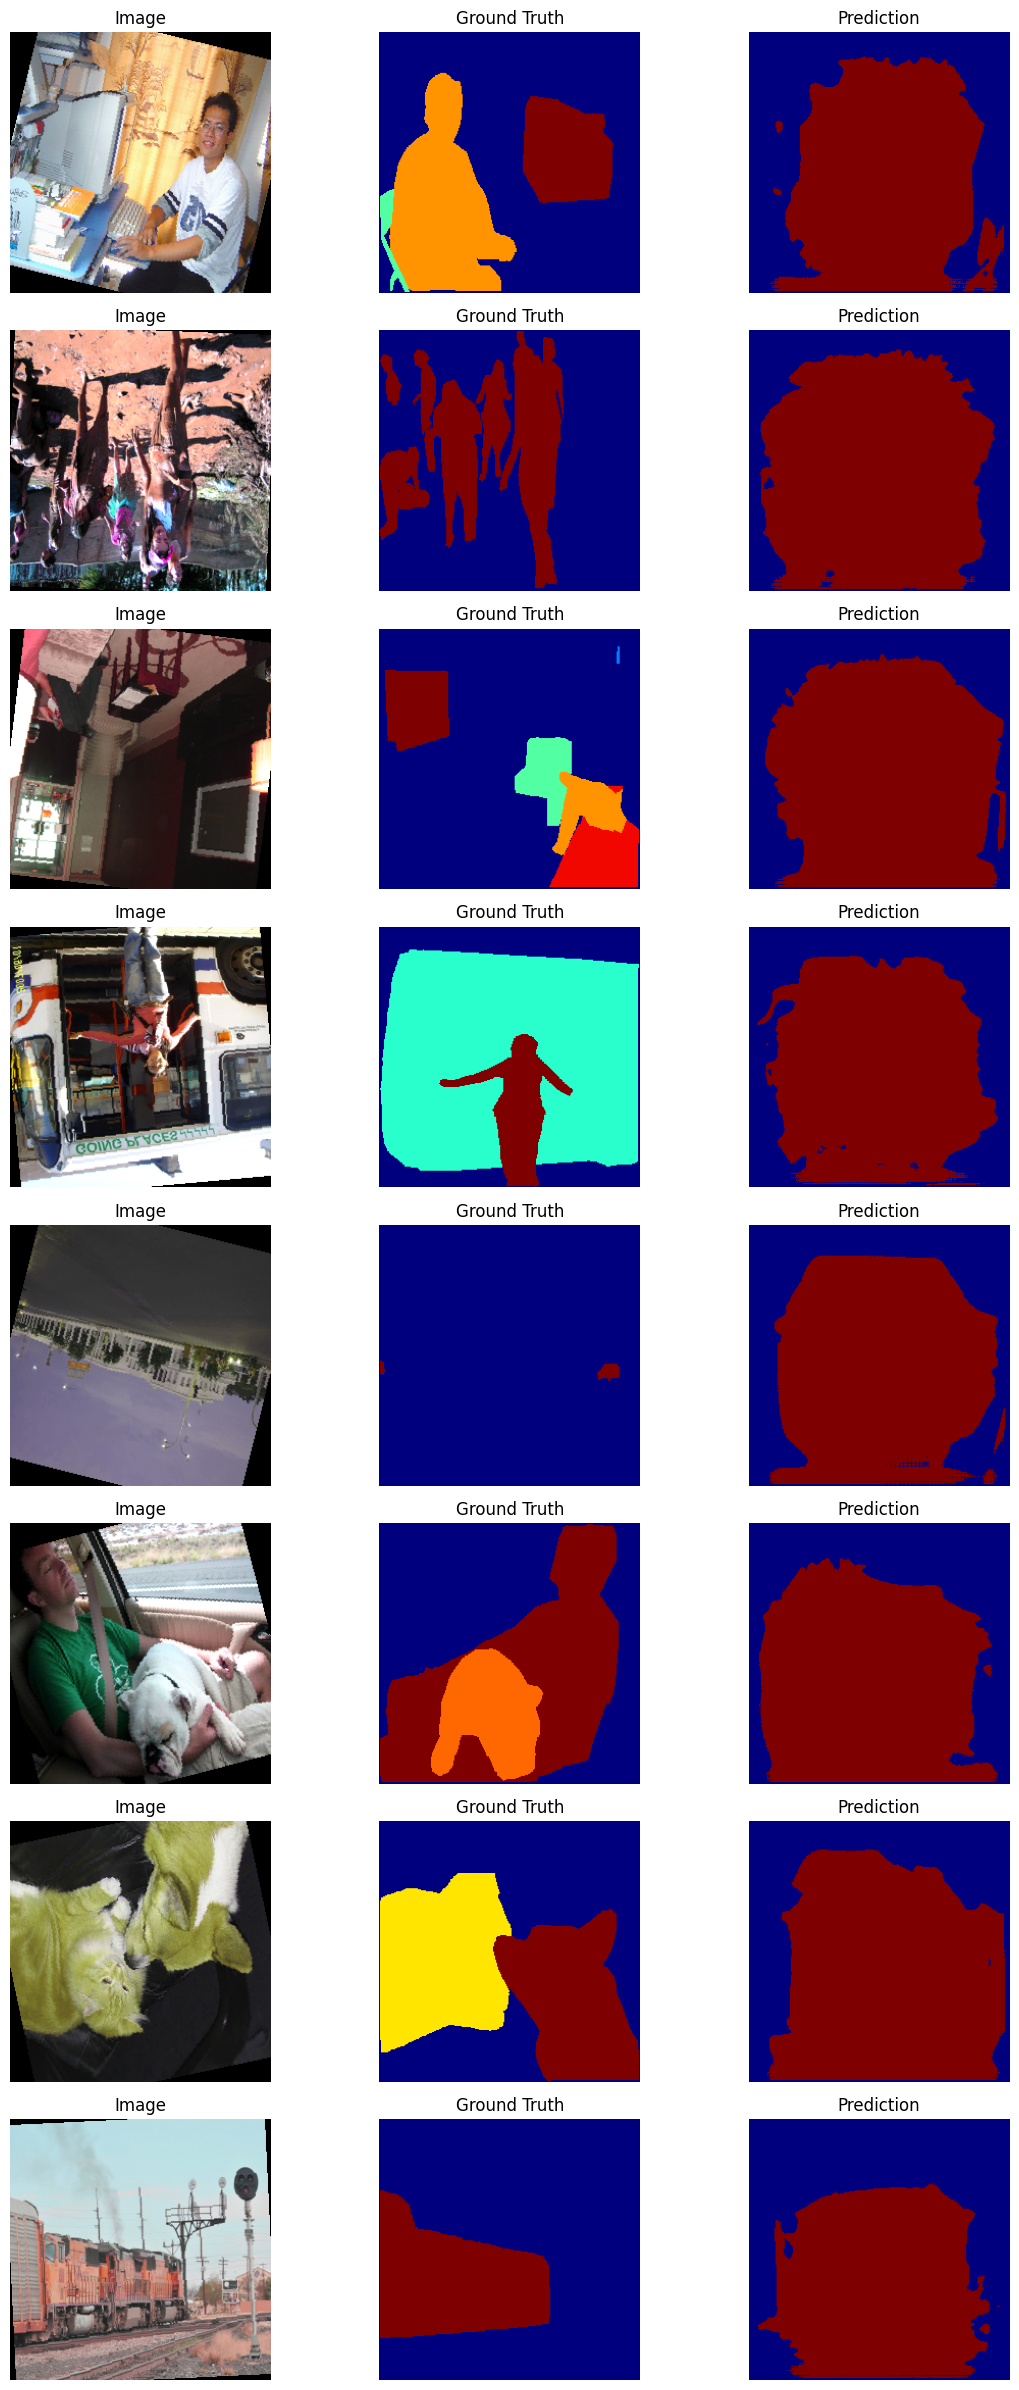

In [ ]:
background_weight = 0.1
weights = torch.tensor(
    [background_weight] + [1.0]*(num_classes-1),
    dtype=torch.float
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255, weight=weights)

model = UNet(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs=9,
    scheduler=scheduler
)
show_predictions_segmentation(model, val_ds, device, n=8)